In [1]:
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import numpy as np
import math

## Mathematical model of the immune response activation including cortisol and glucose dynamics


#### Obs: All the rates are represented per day

In [2]:
# Initial Conditions by experimental data
day = 1440 #min/day
A = 0                  # Cell/mm3 # S. aureus Bacteria               
MA = 5                 #  -       # Macrophages activated
MR = 10                # Cell/mm3 # Macrophages resting
IL_6 = 0               #          # Interleukin-6 (pro-inflammatory)
IL_8 = 0               #          # Interleukin-8 (pro-inflammatory)
IL_10 = 0.7            #          # Interleukin-10 (anti-inflammatory)
TNF = 0.17             #          # Tumor Necrosis Factor a (pro-inflammatory)     
MR_max = 5             #          # Macrophages resting max  
COR = 10               #          # Test value to Cortisol

# Initial Condition to Elliot ODEs
Si = 4                 # mmol     # Fasting stomach glucose
#Si = 120
Di = 14                # mmol     # Fasting intestine glucose
#Di = 14 
Gi = 5                 # mM       # Fasting plasma glucose
#Gi = 10  
Ii = 60                # pM       # Fasting plasma insulin
#Ii = 120
Wi = 10                # pM       # Fasting plasma incretin
#Wi = 30 
Ei = 34                # pM       # Fasting plasma glucagon
Li = 3                 # mmol     # Fasting liver glucose
Mi = 2.5               # mmol     # Fasting muscle glucose
Ai = 53.19             # mmol     # Fasting intra-adipocitary glucose
Yi = 0.4               # nM       # Fasting plasma leptin
Qi = 120               # pM       # Fasting plasma ghrelin
Hi = 200               # mmol     # Glucose intake
IIi = 20               # pM       # Interstitial Insulin
IGi = 135              # mg/kg    # Interstitial Glucose
G4mi = 50.8472         # -        # Glucose transporter 4 in cytosol
G4i = 49.1528          # -        # Glucose transporter 4 in membrane


# Initial Conditions of Each Equation
y0 = [2, MA, MR, IL_10, IL_6, IL_8, TNF, COR, Si, Di, Gi,
      Ii, Wi, Ei, Li, Mi, Ai, Yi, Qi, Hi, IIi, IGi, G4mi, G4i]


## Parameters by Brady et al., (2016):


In [3]:
n_106 = 560            # pg/mL    # Half-maximum value associated with upregulation of IL-10 by IL-6
n_610 = 34.8           # pg/mL    # Half-maximum value associated with downregulation of IL-6 by IL-10
n_66 = 560             # pg/mL    # Half-maximum value associated with the auto-negative feedback of IL-6
n_6TNF = 185           # pg/mL    # Half-maximum value associated with upregulation of IL-6 by TNF-a
n_TNF6 = 560           # pg/mL    # Half-maximum value associated with downregulation of TNF-a by IL-6
n_810 = 17.4           # pg/mL    # Half-maximum value associated with downregulation of IL-8 by IL-10
n_8TNF = 185           # pg/mL    # Half-maximum value associated with upregulation of IL-8 by TNF-a
n_M10 = 4.35           # pg/mL    # 
n_TNF10 = 17.4         # pg/mL    # Half-maximum value associated with downregulation of TNF-a by IL-10
n_MTNF = 0.1           # ?        #  
# n_MTNF = 100  pg/mL (Brady et al., 2016 value)
h_106 = 3.68           # -        # Hill function exponent associated with upregulation of IL-10 by IL-6
h_610 = 4              # -        # Hill function exponent associated with downregulation of IL-6 by IL-10
h_66 = 1               # -        # Hill function exponent associated with auto-negative feedback of IL-6
h_6TNF = 2             # -        # Hill function exponent associated with upregulation of IL-6 by TNF-a
h_TNF6 = 2             # -        # Hill function exponent associated with downregulation of TNF-a by IL-6
h_810 = 1.5            # -        # Hill function exponent associated with downregulation of IL-8 by IL-10
h_8TNF = 3             # -        # Hill function exponent associated with upregulation of IL-8 by TNF-a
h_M10 = 0.3            # -        # 
h_TNF10 = 3            # -        # Hill function exponent associated with downregulation of TNF-a by IL-10
h_MTNF = 3.16          # -        # 
k_MA = 2.51            #          # 
k_MR = 6               #          # 
k_m = 0.0414           #          # 
# k_106 = 0.191 Matlab value
k_106 = 0.0191         # relative cytokine concentration/(day · # of cells)    # Upregulation of IL-10 by IL-6
k_6 = 4.64             # day-1                                                 # Activation rate (per hour) of IL-6
k_6m = 0.01            # relative cytokine concentration/(day · # of cells)    # Upregulation of IL-6 by the activated macrophages
k_6TNF = 0.81          # relative cytokine concentration/(day · # of cells)    # Upregulation of IL-6 by TNF-a
k_8 = 0.464            # day-1                                                 # Activation rate (per hour) of IL-8
k_8m = 0.056           # relative cytokine concentration/(day · # of cells)    # Upregulation of IL-8 by the activated macrophages
k_8TNF = 0.56          # relative cytokine concentration/(day · # of cells)    # Upregulation of IL-8 by TNF-a
k_10 = 1.1             # day-1                                                 # Activation rate (per hour) of IL-10
k_10m = 0.19           # relative cytokine concentration/(day · # of cells)    # Upregulation of IL-10 by the activated macrophages
k_TNF = 200            # day–1                                                 # Activation rate (per hour) of TNF-a
k_TNFM = 1.5           # relative cytokine concentration/(day · # of cells)    # Upregulation of TNF-a by the activated macrophages
k_MTNF = 8.65          # hr-1                                                  # Activation rate of resting macrophages influenced by
q_IL6 = 0.6            # relative concentration                                # The concentration of IL-6 in the absence of a pathogen
q_IL8 = 0.2            # relative concentration                                # The concentration of IL-8 in the absence of a pathogen
q_IL10 = 0.15          # relative concentration                                # The concentration of IL-10 in the absence of a pathogen
q_TNF = 0.14           # relative concentration                                # The concentration of TNF-a in the absence of a pathogendescription

## Parameters by Pritchard-Bell, Ari  (2016):

In [4]:
# Cortisol parameters - Best values

ktc  = 3.43e0         # ng/(pg·min) # The magnitude of cortisol activation by TNF
kmct = 8.69e1         # ng/mL       # 
kmtc = 2.78e1         # pg/mL       # 
kcd  = 1.55e-1        # min^-1      # Cortisol degradation

## Parameters by Quintela et al., (2014):

In [5]:
# In Reference: beta_A = 2
beta_A = 0.02                   # 1/day           # Replication rate of the bacteria
k_A = 50.0                      # mm^3/day        # Carrying capacity of the bacteria
m_Mr = 0.033                     # 1/day          # Natural decay rate of the resting macrophages
m_Ma = 0.07                      # 1/day          # Natural decay rate of the activated macrophages

*Elliot Code:*
## Parameters by Uluseker C et al, (2018):

In [6]:
#barbara
b1 = 0.0059*day           # min^-1              # Insulin independent glucose utilization
b2 = 0.1262*day           # min^-1              # Insulin disappearance rate
b3 = 0.00005*day          # (pM * min)-1        # Insulin dependent glucose utilization
b4 = 0.4543*day           # pM ∕ mM * min       # Glucose dependent insulin secretion
b5 = 0.185*day            # min^-1              # Glucose transfer from liver to plasma
b6 = 0.0102*day           # pM ∕ mmol * min     # Intestine glucose dependent incretin secretion
b7 = 0.03*day             # min^-1              # Incretin disappearance rate
b8 = 0.022*day            # min^-1              # Stomach glucose emptying rate
b9 = 0.022*day            # min^-1              # Glucose transfer rate to the stomach
b10 = 0.022*day           # min^-1              # Intestine glucose emptying rate
b11 = 0.02*day            # min^-1              # Ghrelin disappearance
b12 = 286.6           # pM ∕ min            # The appearance constant for ghrelin
#b12 = 28.66
b13 = 0.0000095*day       # nM / mmol*min*kg    # Leptin secretion rate
b14 = 0.0278*day          # min^-1              # Leptin disappearance
b17 = 0.7*day             # mmol ∕ pM * min     # Ghrelin dependent glucose intake appearance
b18 = 0.35*day                # nM^-1               # Leptin inhibition on glucose intake
b19 = 0.004*day           # (mM * min)^-1       # Glucose effect rate on glucose intake
b21 = 0.00876*day         # mmol ∕ min* pM      # Glucagon action on the liver
b22 = 0.0021*day          # min^-1              # Glucose action on the liver
b23 = 0.08*day            # mmol ∕ min          # Liver glucose constant production
b25 = 0.00026*day         # mmol ∕ min* pM      # Insulin action on the liver
b27 = 0.014*day           # min^-1              # Muscle glucose disappearance
c = 0.1060*day            # (mM * min)^-1       # Incretin dependent insulin secretion
c0 = 1.8854           # pM ∕ min            # Glucagon basal secretion
c1 = 198              # (pM * nM ∕ min)     # Glucose action on Glucagon
c2 = 940.                  # pM                  # Insullin action on glucagon
#c2 = 94
c3 = 0.0554           # min^-1              # Glucagon disappearance
e = 1.0                   #  -                  # Insulin effectiveness
Fat = 22.0                # kg                  # Averaged total fat mass in humans (kg)
a1 = 0.9                  # -                   # Fraction of absorbed glucose
Gb = 5                    # min(G)              # Fasting plasma glucose (Basal level; mM) calculated using min(G)
Ge = 5.0                  # mM                  # Glucose threshold value (mM)
Ib = 46.5                 # min(l)              # Fasting plasma insulin (Basal level; pM) calculated using min(I)
k7a = 51              # min^-1              # Translocation of GLUT4 to the membrane (min^-1)
k7b = 2290           # min^-1              # Translocation of GLUT4 to the cytosol (min^-1)
k8 = 0.5275           # mmol/min            # GLUT4 glucose uptake (mmol/min)
kmG1 = 1.082              # mg/kg               # Dependence on interstitial glucose saturated (mg/kg)
kmG4 = 146.851            #  mg/kg              # Dependence on interstitial glucose saturated (mg/kg)
l = 0.006                  # mmol^-1             # Glucose in stomach dependent decay rate of ghrelin (mmol^-1)
m = 0.04                 # pM^-1               # Insulin dependent decay rate of ghrelin (pM^-1)
p2U = 0.033           # min^-1              # Interstitial insulin rate of change (min^-1)
q1 = 0.0031           # min^-1              # Interstitial glucose elimination rate (min^-1)
q2 = 0.4054           # (mg/kg)/mM.min      # Glucose transger rate from plasma to interstitium ((mg/kg)/mM.min)
r = 0.04*day                 # pM^-1               # Insulin depdent decay rate of glucose intake (pM^-1)
s = 0.03*day              # pM/min              # Incretin constant secretion (pM/min)
v = 15                    # liters              # Glucose distribution volume (liters)
GLUT1 = 0.0283       # mmol/min            # GLUT1 glucose uptake (mmol/min)
AS160_T642P = 43.4059     # ?                   # Substrate of PKB (phosphorylated)


In [7]:
# Simulation Parameters
sim_time = 1        # min/day        # Total time of simulation in min 
deltaT = pow(10, -4)   # -              # Step size

t = np.arange(0,sim_time,deltaT)
#t= np.arange(0,525960) #1 day == 1440min   # 365 year == 525600min
#t= np.arange(0,1400) #24 hours, 1 datapoint per minute ELLIOT

## ODE System

In [8]:
def f(y, t):
    A = y[0]
    MA = y[1]
    MR = y[2]
    IL10 = y[3]
    IL6 = y[4]
    IL8 = y[5]
    TNF = y[6]
    COR = y[7]
     
    #Elliot ODEs
    Si = y[8] 
    Di = y[9] 
    Gi = y[10]
    Ii = y[11]
    Wi = y[12]
    Ei = y[13]
    Li = y[14]
    Mi = y[15]
    Ai = y[16]
    Yi = y[17]
    Qi = y[18]
    Hi = y[19]
    IIi = y[20]
    IGi = y[21]
    G4mi = y[22]
    G4i = y[23]


    #dAdt = (beta_A * A *(1 - (A / k_A)) - m_A * A * MA)
    dAdt = beta_A * A *(1-A/k_A)  - m_Mr * A * MR - m_Ma * A * MA
    
    dMAdt = ((k_m + k_MTNF * pow(TNF, h_MTNF) / (pow(n_MTNF, h_MTNF) + pow(TNF, h_MTNF)) * (pow(n_M10, h_M10) / (pow(n_M10, h_M10)\
         + pow(IL10, h_M10)))) * MR * A - k_MA * MA)
    
    dMRdt = ((-(k_m + k_MTNF * (pow(TNF, h_MTNF) / (pow(n_MTNF, h_MTNF) + pow(TNF, h_MTNF))) * (pow(n_M10, h_M10) / (pow(n_M10, h_M10)\
         + pow(IL10, h_M10)))) * MR * A + k_MR * MR) + k_MR * MR * (1 - MR / MR_max))
    
    dIL10dt = ((k_10m + k_106 * (pow(IL6, h_106) / (pow(n_106, h_106) + pow(IL6, h_106)))) * MA - k_10 * (IL10 - q_IL10))
    
    dIL6dt = ((k_6m + k_6TNF * (pow(TNF, h_6TNF) / (pow(n_6TNF, h_6TNF) + pow(TNF, h_6TNF))) * (pow(n_66, h_66) / (pow(n_66, h_66)\
         + pow(IL6, h_66))) * (pow(n_610, h_610) / (pow(n_610, h_610) + pow(IL10, n_610)))) * MA - k_6 * (IL6 - q_IL6))
    
    dIL8dt = ((k_8m + k_8TNF * (pow(TNF, h_8TNF) / (pow(TNF, h_8TNF) + pow(n_8TNF, h_8TNF))) * (pow(n_810, h_810) / (pow(n_810, h_810)\
         + pow(IL10, h_810)))) * MA - k_8 * (IL8 - q_IL8))
    
    #dTNFdt = ((k_TNFM * (pow(n_TNF6, h_TNF6) / (pow(n_TNF6, h_TNF6) \
     #         + pow(IL6, h_TNF6))) * (pow(n_TNF10, h_TNF10) / (pow(n_TNF10, h_TNF10)\
      #        + pow(IL10, h_TNF10)))) * (1-COR/(COR+kmct)) * MA   \
       #       - k_TNF * (TNF - q_TNF))
    
    dTNFdt = (k_TNFM * (pow(n_TNF6, h_TNF6) / (pow(n_TNF6, h_TNF6) \
              + pow(IL6, h_TNF6))) * (pow(n_TNF10, h_TNF10) / (pow(n_TNF10, h_TNF10)\
              + pow(IL10, h_TNF10)))) * COR * MA  - k_TNF * (TNF - q_TNF)
    
    #dCORdt = (((ktc * TNF)/(TNF + kmtc)) - kcd*COR)
    dCORdt = ktc*TNF- kcd*COR

    # Elliot Equations
    dSdt = b9*Hi - b8*Si

    dLdt = b8*Si - b10*Di

    dGdt = a1*((b10*Di)/v) + a1*((b5*Li)/v) - b1*Gi - b3*Ii*Gi          
    
    dIdt = b4*Gi + c*Wi*Gi - b2*Ii                                            
    
    dWdt = b6*Di - b7*Wi + s
    
    dEdt = c0 + (c1/(c2+Ii*e))*(Ge-Gi)*np.heaviside(Ge-Gi, 1) - c3*Ei
    
    dCdt = b23 - b25*Ii*e - b22*Gi + b21*Ei - b5*Li
    
    dMdt = 0.1*(v/a1)*b3*Gi*Ii*e - b27*Mi
    
    dAdt2 = k8*G4mi*(IGi/(kmG4+IGi)) + GLUT1*(IGi/(kmG1+IGi)) - 0.1*Ai 
    
    dYdt = b13*Ai*Fat - b14*Yi 
    
    dQdt = b12*math.exp(-l*Si)*math.exp(-m*Ii) - b11*Qi
    
    dHdt= (b17*Qi)/(b18*Yi + 1) * math.exp(-r*Ii) - b19*Gi*Hi - b9*Hi 
    
    dINSdt = -p2U*IIi + p2U*(Ii-Ib)
    
    dGtdt = -q1*IGi + q2*(Gi-Gb)
    
    dGLUT4mdt = k7a*G4i*AS160_T642P - k7b*G4mi
     
    dGLUT4dt = -k7a*G4i*AS160_T642P + k7b*G4mi 

    return [dAdt, dMAdt, dMRdt, dIL10dt, dIL6dt, dIL8dt, dTNFdt, dCORdt,
            dSdt, dLdt, dGdt, dIdt, dWdt, dEdt, dCdt, dMdt, dAdt2, dYdt, dQdt,
            dHdt, dINSdt, dGtdt, dGLUT4mdt, dGLUT4dt]

# Solution with odeint() function
sol = odeint(f, y0, t)

out_A = sol[:, 0]
out_MA = sol[:, 1]
out_MR = sol[:, 2]
out_IL10 = sol[:, 3]
out_IL6 = sol[:, 4]
out_IL8 = sol[:, 5]
out_TNF = sol[:, 6]
out_COR = sol[:, 7]
 
out_S = sol[:,8]
out_D = sol[:,9]
out_G = sol[:,10]
out_I = sol[:,11]
out_W = sol[:,12]
out_E = sol[:,13]
out_L = sol[:,14]
out_M = sol[:,15]
out_A2 = sol[:,16]
out_Y = sol[:,17]
out_Q = sol[:,18]
out_H = sol[:,19]
out_II = sol[:,20]
out_IG = sol[:,21]
out_G4m = sol[:,22]
out_G4 = sol[:,23]

# Normalization
out_TNF = 100 * (out_TNF - min(out_TNF)) / (max(out_TNF) - min(out_TNF))
out_IL6 = 100 * (out_IL6 - min(out_IL6)) / (max(out_IL6) - min(out_IL6))
out_IL8 = 100 * (out_IL8 - min(out_IL8)) / (max(out_IL8) - min(out_IL8))
out_IL10 = 100 * (out_IL10 - min(out_IL10)) / (max(out_IL10) - min(out_IL10))

## Plots: 

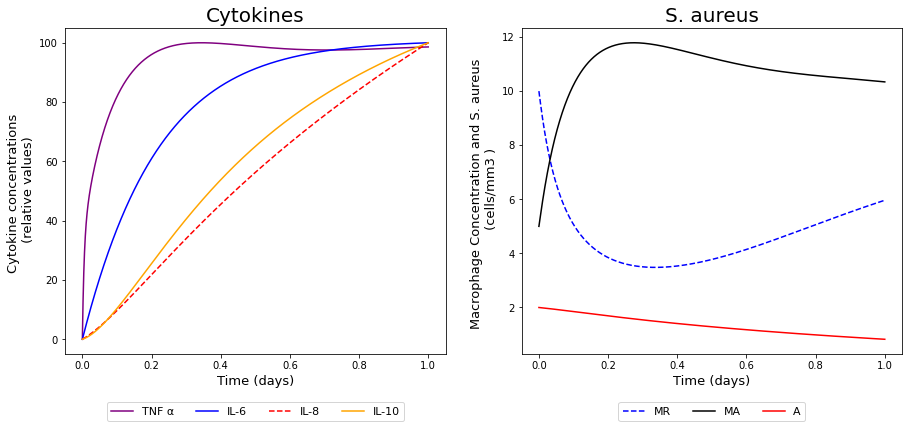

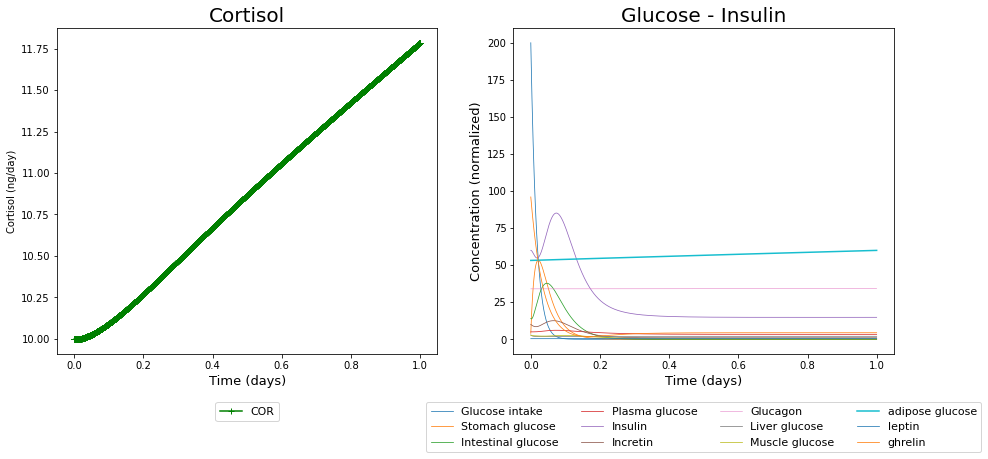

In [9]:
fig, (ax1, ax2) = plt.subplots(1,2)
#fig.suptitle("Python Charts", fontsize = 25)

# Cytokines
ax1.plot(t, out_TNF,'purple', label="TNF α")
ax1.plot(t, out_IL6, 'b', label="IL-6")
ax1.plot(t, out_IL8, 'r--', label="IL-8")
ax1.plot(t, out_IL10, 'orange', label="IL-10")

ax1.set_title("Cytokines", fontsize = 20)
ax1.legend( ncol = 4, bbox_to_anchor = (0.5,-0.13), loc='upper center', fontsize = 11)
ax1.set_xlabel('Time (days)', fontsize = 13)
ax1.set_ylabel('Cytokine concentrations \n (relative values)', fontsize = 13)

# S. aureus
#ax2.set_yscale('log')
ax2.plot(t, out_MR, 'b--', label="MR")
ax2.plot(t, out_MA, 'black', label="MA")
ax2.plot(t, out_A,'r', label="A")
#ax2.plot(t, out_F,'b', label="F")

ax2.set_title("S. aureus", fontsize = 20)
ax2.legend( ncol = 4, bbox_to_anchor = (0.5,-0.13), loc='upper center', fontsize = 11)
ax2.set_xlabel('Time (days)', fontsize = 13)
ax2.set_ylabel('Macrophage Concentration and S. aureus \n (cells/mm3 )', fontsize = 13)

#fig.savefig('Downloads/cytokines.png')

fig.set_figwidth(15) 
fig.set_figheight(6) 

plt.show()
print("\n\n\n")

fig, (ax3, ax4) = plt.subplots(1,2)

# Cortisol
ax3.set_ylabel('Cortisol (ng/day)')
ax3.plot(t, out_COR,'g' , marker = '+', label="COR")
ax3.set_title("Cortisol", fontsize = 20)
ax3.legend( ncol = 4, bbox_to_anchor = (0.5,-0.13), loc='upper center', fontsize = 11)
ax3.set_xlabel('Time (days)', fontsize = 13)



# Glucose - Insulin
ax4.plot(t, out_H, label="Glucose intake", linewidth=0.75)     #/175
ax4.plot(t, out_S, label="Stomach glucose", linewidth=0.75)    #135
ax4.plot(t, out_D, label="Intestinal glucose", linewidth=0.75) #125
ax4.plot(t, out_G, label="Plasma glucose", linewidth=0.75)     #/20
ax4.plot(t, out_I, label="Insulin", linewidth=0.75)            #/500
ax4.plot(t, out_W, label="Incretin", linewidth=0.75)
ax4.plot(t, out_E, label="Glucagon", linewidth=0.5)
ax4.plot(t, out_L, label="Liver glucose", linewidth=0.75)      #*20
ax4.plot(t, out_M, label="Muscle glucose", linewidth=0.75)     #*7.5
plt.plot(t, out_A2, label="adipose glucose")
ax4.plot(t, out_Y, label="leptin", linewidth=0.75)
ax4.plot(t, out_Q/1.25, label="ghrelin", linewidth=0.75)
#plt.plot(t, II, label="interstitial insulin") 
#plt.plot(t, IG, label="interstitial glucose")                 #/700
ax4.set_title("Glucose - Insulin", fontsize = 20)
ax4.set_xlabel("Time (days)", fontsize = 13)
ax4.set_ylabel("Concentration (normalized)", fontsize = 13)
ax4.legend(ncol = 4, bbox_to_anchor = (0.5,-0.13), loc='upper center', fontsize = 11)

#fig.savefig('Downloads/cortisol.png')
fig.set_figwidth(15) 
fig.set_figheight(6) 

#plt.show()